# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# TODO: Make all necessary imports.
import numpy as np
import matplotlib.pyplot as plt

import json

import tensorflow as tf

import tensorflow_datasets as tfds

In [2]:
import tensorflow_hub as hub

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10390332661390200051
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4140236800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1798086093788580280
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.config.list_physical_devices('GPU') else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.5.0
	• tf.keras version: 2.5.0
	• Running on GPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [5]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

name: "oxford_flowers102"
description: "\nThe Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring\nin the United Kingdom. Each class consists of between 40 and 258 images. The images have\nlarge scale, pose and light variations. In addition, there are categories that have large\nvariations within the category and several very similar categories.\n\nThe dataset is divided into a training set, a validation set and a test set.\nThe training set and validation set each consist of 10 images per class (totalling 1030 images each).\nThe test set consist of the remaining 6129 images (minimum 20 per class).\n"
citation: "@InProceedings{Nilsback08,\n   author = \"Nilsback, M-E. and Zisserman, A.\",\n   title = \"Automated Flower Classification over a Large Number of Classes\",\n   booktitle = \"Proceedings of the Indian Conference on Computer Vision, Graphics and Image Processing\",\n   year = \"2008\",\n   month = \"Dec\"\n}\n"
size_in_bytes: 344878000
locatio

2021-07-24 23:18:55.237722: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
I0724 23:18:57.137273 49768 download_and_prepare.py:170] Running download_and_prepare for datasets:
oxford_flowers102
I0724 23:18:57.137273 49768 download_and_prepare.py:172] Version: "None"
W0724 23:18:57.138243 49768 dataset_builder.py:575] Found a different version 2.1.1 of dataset oxford_flowers102 in data_dir C:\Users\Ahmad\tensorflow_datasets. Using currently defined version 0.0.1.
I0724 23:18:57.138243 49768 dataset_builder.py:184] Overwrite dataset info from restored data version.
I0724 23:18:57.148216 49768 download_and_prepare.py:122] download_and_prepare for dataset oxford_flowers102/0.0.1...
I0724 23:18:57.148216 49768 dataset_builder.py:253] Reusing dataset oxford_flowers102 (C:\Users\Ahmad\tensorflow_datasets\oxford_flowers102\0.0.1)


In [6]:
# TODO: Load the dataset with TensorFlow Datasets.
data, data_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)

In [7]:
# TODO: Create a training set, a validation set and a test set.
data_train = data['train']
data_test = data['test']
data_validation = data['validation']

In [8]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

## Explore the Dataset

In [9]:
print(data_info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=0.0.1,
    description='
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1030 images each).
The test set consist of the remaining 6129 images (minimum 20 per class).
',
    urls=['https://www.robots.ox.ac.uk/~vgg/data/flowers/102/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=81

In [10]:
# TODO: Get the number of examples in each set from the dataset info.
print("Training data has '{:,}' example.".format(len(list(data_train))))
print("Testing data has '{:,}' example.".format(len(list(data_test))))
print("Validation data has '{:,}' example.".format(len(list(data_validation))))

Training data has '1,020' example.
Testing data has '6,149' example.
Validation data has '1,020' example.


In [11]:
# TODO: Get the number of classes in the dataset from the dataset info.
print("Number of classes in dataset is '{}'.".format(data_info.features['label'].num_classes))

Number of classes in dataset is '102'.


In [12]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
print('The images in the training set have:\n')
for image, label in data_train.take(3):
    print('-----------------------------------------')
    print('\u2022 dtype:', image.dtype) 
    print('\u2022 shape:', image.shape)
  
    print('\nThe labels of the images have:')
    print('\u2022 dtype:', label.dtype) 


The images in the training set have:

-----------------------------------------
• dtype: <dtype: 'uint8'>
• shape: (500, 666, 3)

The labels of the images have:
• dtype: <dtype: 'int64'>
-----------------------------------------
• dtype: <dtype: 'uint8'>
• shape: (752, 500, 3)

The labels of the images have:
• dtype: <dtype: 'int64'>
-----------------------------------------
• dtype: <dtype: 'uint8'>
• shape: (711, 500, 3)

The labels of the images have:
• dtype: <dtype: 'int64'>


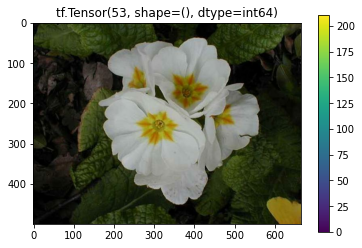

The label is 53


In [53]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in data_train.take(1):
    image = image.numpy().squeeze()
    label = label
    
    #plot the image
    plt.imshow(image)
    plt.colorbar()
    plt.title(str(label+1))
    plt.show()

    print('The label is {}'.format(label+1))

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [14]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

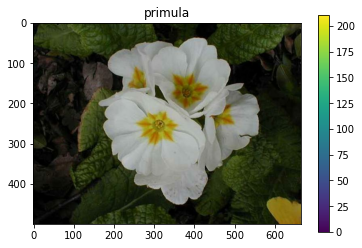

The label is 'primula' | label Num: '53'


In [52]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in data_train.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
    #plot the image
    plt.imshow(image)
    plt.colorbar()
    plt.title(class_names[str(label+1)])
    plt.show()

print("The label is '{}' | label Num: '{}'".format(class_names[str(label+1)], str(label+1)))

## Create Pipeline

In [16]:
# TODO: Create a pipeline for each set.
batch_size = 64

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255
    return image, label


train_batches = data_train.cache().shuffle(len(list(data_train))).map(normalize).batch(batch_size).prefetch(1)
test_batches = data_test.cache().shuffle(len(list(data_test))).map(normalize).batch(batch_size).prefetch(1)
validation_batches = data_validation.cache().shuffle(len(list(data_validation))).map(normalize).batch(batch_size).prefetch(1)

In [17]:
for image_batch, label_batch in train_batches.take(1):
    print('The images in each batch have:')
    print('\u2022 dtype:', image_batch.dtype) 
    print('\u2022 shape:', image_batch.shape)
  
    print('\nThere are a total of {} image labels in this batch:'.format(label_batch.numpy().size))
    print(label_batch.numpy())

The images in each batch have:
• dtype: <dtype: 'float32'>
• shape: (64, 224, 224, 3)

There are a total of 64 image labels in this batch:
[ 87   7  30  69  37   0  15  86  19  88  75  26  98  31  90  96  47  60
  80  61  94  50  84  23  42  82  24  48  99   2  13  29  88  92  76  52
  66  20   4  56  86  27  78  94  60  27   1  85  79  22  61  57  80  40
 100  48  32  93  90  62  63  12   3  51]


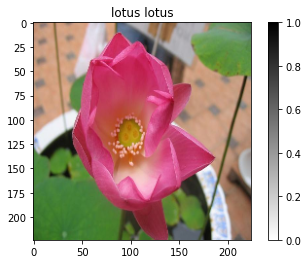

Image Shape: (224, 224, 3)
The label is 'lotus lotus' | label Num: '78'


In [50]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
i = 0
for image, label in train_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()
    
    #plot the image
    plt.imshow(images[i], cmap = plt.cm.binary)
    plt.colorbar()
    plt.title(class_names[str(labels[i]+1)])
    plt.show()
    
    print("Image Shape: {}".format(images[i].shape))
    print("The label is '{}' | label Num: '{}'".format(class_names[str(labels[i]+1)], str(labels[i]+1)))
    i += 1

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

In [19]:
# load the pre-trained model.
loaded_model = hub.KerasLayer(
  'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
)

In [20]:
# Clear session.
tf.keras.backend.clear_session()

# Images size.
IMAGE_SIZE = (224, 224, 3)

# make new model
model = tf.keras.Sequential()

# load model.
model.add(hub.KerasLayer(loaded_model, input_shape = IMAGE_SIZE))

# dropout with rate 0.75.
model.add(tf.keras.layers.Dropout(rate=0.75))

# output layer.
model.add(tf.keras.layers.Dense(102, activation = 'softmax'))

# build.
model.build([None, IMAGE_SIZE])

# show summary.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
dropout (Dropout)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               102204    
Total params: 3,642,469
Trainable params: 102,204
Non-trainable params: 3,540,265
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# check the accurasy before training
for image_batch, label_batch in train_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

2/2 [==============================] - 5s 36ms/step - loss: 6.0316 - accuracy: 0.0156

Loss before training: 6.032
Accuracy before training: 1.562%


In [23]:
# train the model.
history = model.fit(
  train_batches,
  epochs=20,
  validation_data=validation_batches
)

Epoch 1/20
16/16 [==============================] - 7s 223ms/step - loss: 8.5622 - accuracy: 0.0157 - val_loss: 4.4634 - val_accuracy: 0.0696
Epoch 2/20
16/16 [==============================] - 2s 134ms/step - loss: 6.7445 - accuracy: 0.0245 - val_loss: 3.3597 - val_accuracy: 0.2343
Epoch 3/20
16/16 [==============================] - 2s 134ms/step - loss: 5.5827 - accuracy: 0.0980 - val_loss: 2.5836 - val_accuracy: 0.4167
Epoch 4/20
16/16 [==============================] - 2s 134ms/step - loss: 4.6283 - accuracy: 0.1559 - val_loss: 2.0603 - val_accuracy: 0.5333
Epoch 5/20
16/16 [==============================] - 2s 133ms/step - loss: 3.6534 - accuracy: 0.2725 - val_loss: 1.7108 - val_accuracy: 0.6255
Epoch 6/20
16/16 [==============================] - 2s 134ms/step - loss: 2.9984 - accuracy: 0.3343 - val_loss: 1.4655 - val_accuracy: 0.6775
Epoch 7/20
16/16 [==============================] - 2s 134ms/step - loss: 2.6412 - accuracy: 0.3912 - val_loss: 1.2981 - val_accuracy: 0.7010
Epoch 

In [24]:
#check the accurasy after training
for image_batch, label_batch in train_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

2/2 [==============================] - 0s 35ms/step - loss: 0.0767 - accuracy: 1.0000

Loss after training: 0.077
Accuracy after training: 100.000%


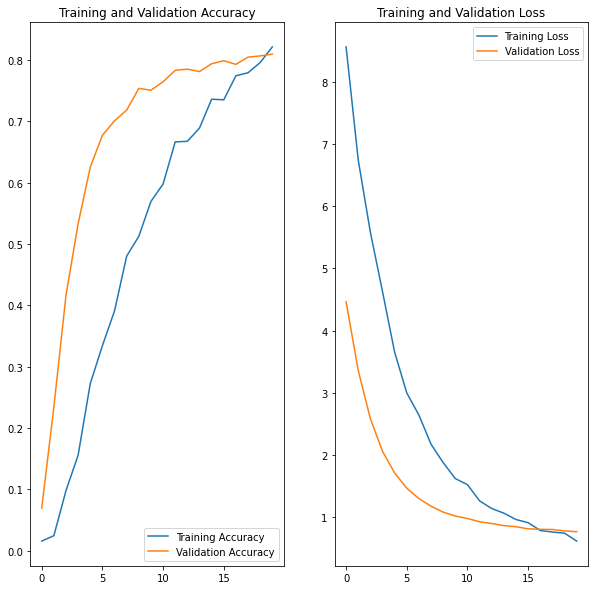

In [25]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(20)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [37]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
for image_batch, label_batch in test_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nModel loss: {:,.3f}'.format(loss))
print('Model accuracy: {:.3%}'.format(accuracy))

2/2 [==============================] - 0s 44ms/step - loss: 0.6522 - accuracy: 0.8438

Model loss: 0.652
Model accuracy: 84.375%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [27]:
# TODO: Save your trained model as a Keras model.
filepath = 'savedModel.h5'

tf.saved_model.save(model, filepath)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: savedModel.h5\assets


INFO:tensorflow:Assets written to: savedModel.h5\assets


## Load the Keras Model

Load the Keras model you saved above.

In [28]:
# TODO: Load the Keras model
reloaded_SavedModel = tf.keras.models.load_model(filepath)

reloaded_SavedModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
dropout (Dropout)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               102204    
Total params: 3,642,469
Trainable params: 102,204
Non-trainable params: 3,540,265
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [29]:
# TODO: Create the process_image function
def process_image(image):
    new_image = tf.convert_to_tensor(image, dtype = tf.float32)
    new_image = tf.image.resize(new_image, (224, 224))
    new_image /= 255
    return new_image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

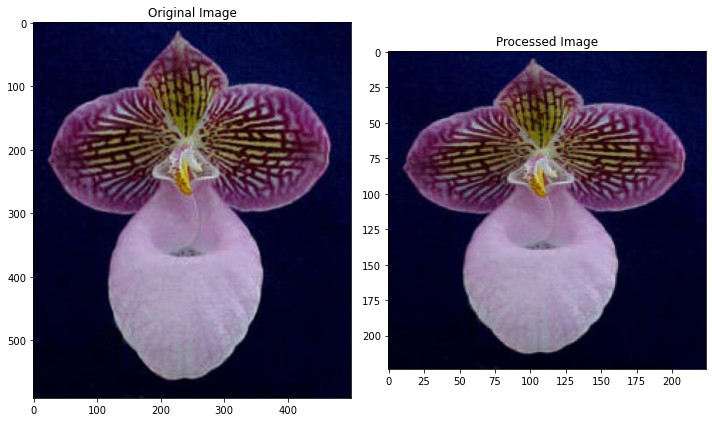

In [30]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [120]:
# add 1 to label
def labelPlus1(label):
    return label+1
    
def predict(image_path, model, top_k):
    # open image.
    im = Image.open(image_path)
    # process the image.
    procesed_image = process_image(np.asarray(im))
    # expand the image shape from (224, 224, 3) to (1, 224, 224, 3).
    expanded_image = np.expand_dims(procesed_image, axis=0)
    # make a predict.
    imagePredicts = model.predict(expanded_image)
    imagePredicts = imagePredicts.tolist()
    
    probs, classes = tf.math.top_k(imagePredicts, k = top_k)
    
    classes = tf.map_fn(labelPlus1, classes)
    
    probs = probs.numpy().tolist()[0]
    classes = classes.numpy().tolist()[0]
    return probs, classes

In [121]:

# method to get the flowers name instead of label number.
def getNames(classes):
    classes_names = []
    for i in classes:
        classes_names.append(class_names[str(i)])
    return classes_names

In [122]:
# test predict function.
probs, classes = predict(image_path, model, 5)
print('Probabilities:\n{}'.format(probs))
print('\nClasses Numbers:\n{}'.format(classes))
# test getNames function
print('\nClasses Names:\n{}'.format(getNames(classes)))

Probabilities:
[0.9997662901878357, 0.00012915104161947966, 2.9960936444695108e-05, 1.8516457203077152e-05, 1.1852306670334656e-05]

Classes Numbers:
[2, 80, 7, 91, 77]

Classes Names:
['hard-leaved pocket orchid', 'anthurium', 'moon orchid', 'hippeastrum', 'passion flower']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

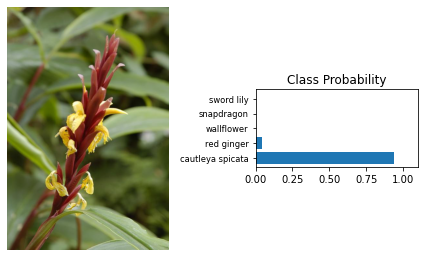

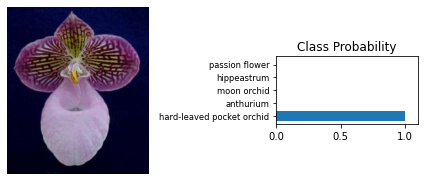

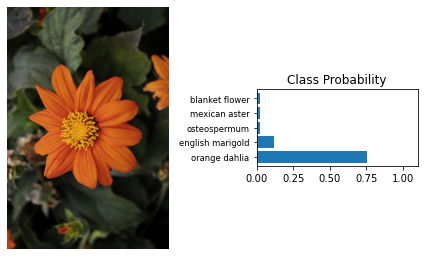

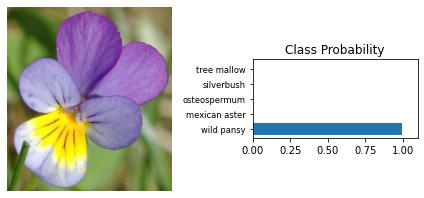

In [123]:
# TODO: Plot the input image along with the top 5 classes
import os

def plot(image, best_5_predicts, top_labels):
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image, cmap = plt.cm.binary)
    ax1.axis('off')
    ax2.barh(np.arange(5), best_5_predicts)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(np.arange(5))
    ax2.set_yticklabels(top_labels, size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()
    
# go through all photos in "test_images" folder
for photo in os.listdir('./test_images'):
    # get photo path ('floder path' + / + 'photo name')
    path = './test_images/{}'.format(photo)
    # open the image
    im = Image.open(path)
    # to array
    im_array = np.asarray(im)

    probs, classes = predict(path, model, 5)

    plot(im_array, probs, getNames(classes))

## Sources Used:
________________________________________________________________________
### for part 1:
#### 1- https://www.youtube.com/watch?v=hHWkvEcDBO0&ab_channel=AladdinPersson
#### 2- Udacity videos and notebooks on Lesson 4: Deep Learning with TensorFlow (some codes was inspierd from it)
#### 3- https://www.tensorflow.org/hub/tutorials/tf2_image_retraining
#### 4- https://www.tutorialspoint.com/numpy/numpy_expand_dims.htm
#### 5 - https://www.tensorflow.org/api_docs/python/tf/math/top_k
#### 6- https://www.youtube.com/watch?v=tJxcKyFMTGo&ab_channel=CoreySchafer
#### 7-https://www.youtube.com/watch?v=r6Cn3hjFvsI&ab_channel=WebDevPro
________________________________________________________________________
### for part 2:
#### 1- https://docs.python.org/3/howto/argparse.html
#### 2- https://www.youtube.com/watch?v=cdblJqEUDNo